In [ ]:
#1. Khám phá và làm sạch dữ liệu
import pandas as pd
from datetime import datetime

# Đọc file dữ liệu từ đường dẫn cụ thể
file_path = r"D:\KỲ 2 2024-2025\PYTHON\superstore_dataset.xlsx"
df = pd.read_excel(file_path)

# Thông tin tổng quát
print(">>> Thông tin tổng quát về dữ liệu:")
print(df.info())

# Kích thước ban đầu
print(f"\n>>> Kích thước ban đầu: {df.shape[0]} dòng, {df.shape[1]} cột")

# Xem trước dữ liệu
print("\n>>> 5 dòng đầu của dữ liệu gốc:")
print(df.head())

# Hiển thị thống kê mô tả theo chiều ngang
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("\n>>> Thống kê mô tả tổng quan (dạng ngang):")
print(df.describe(include='all').T)

# Kiểm tra giá trị null trong từng cột
print("\n>>> Kiểm tra số lượng giá trị null trong mỗi cột:")
print(df.isnull().sum())

# Chuyển đổi kiểu dữ liệu
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
df['Ship_Date'] = pd.to_datetime(df['Ship_Date'], errors='coerce')

# Kiểm tra điều kiện lỗi
invalid_sales = df['Sales'].isna() | (df['Sales'] <= 0)
invalid_order_date = df['Order_Date'].isna() | (df['Order_Date'] > datetime.now())
invalid_ship_date = df['Ship_Date'].isna() | (df['Ship_Date'] > datetime.now()) | (df['Ship_Date'] < df['Order_Date'])

# Tổng hợp thông tin lỗi
print("\n>>> Số dòng có 'Sales' không hợp lệ (null hoặc <= 0):", invalid_sales.sum())
print(">>> Số dòng có 'Order_Date' không hợp lệ (null hoặc > hiện tại):", invalid_order_date.sum())
print(">>> Số dòng có 'Ship_Date' không hợp lệ (null, > hiện tại, hoặc trước Order_Date):", invalid_ship_date.sum())

# Chuẩn hóa tên cột
df.columns = df.columns.str.strip()

# Xóa dòng trống hoàn toàn
df.dropna(how='all', inplace=True)

# Giữ lại các cột cần cho phân tích RFM
columns_to_keep = ["Customer_ID", "Order_Date", "Order_ID", "Sales"]
df = df[columns_to_keep]

# Kích thước sau xử lý
print(f"\n>>> Kích thước sau khi làm sạch: {df.shape[0]} dòng, {df.shape[1]} cột")

# Xem trước dữ liệu đã làm sạch
print("\n>>> 5 dòng đầu của dữ liệu sau xử lý:")
print(df.head())

# Lưu dữ liệu sau xử lý
output_path = r"D:\KỲ 2 2024-2025\PYTHON\superstore_clean_1000_processed.xlsx"
df.to_excel(output_path, index=False)

print(f"\n>>> Dữ liệu đã làm sạch và lưu tại: {output_path}")

>>> Thông tin tổng quát về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order_ID       1000 non-null   object        
 1   Order_Date     1000 non-null   datetime64[ns]
 2   Ship_Date      1000 non-null   datetime64[ns]
 3   Ship_Mode      1000 non-null   object        
 4   Customer_ID    1000 non-null   object        
 5   Customer_Name  1000 non-null   object        
 6   Segment        1000 non-null   object        
 7   Country        1000 non-null   object        
 8   City           1000 non-null   object        
 9   State          1000 non-null   object        
 10  Postal_Code    1000 non-null   int64         
 11  Region         1000 non-null   object        
 12  Product_ID     1000 non-null   object        
 13  Sub_Category   1000 non-null   object        
 14  Product_Name   1000 non-null   object

In [ ]:
#2.Code phân tích RFM
import pandas as pd

# Đọc file Excel
file_path =r"D:\KỲ 2 2024-2025\PYTHON\superstore_clean_1000_processed.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# Chuyển đổi cột ngày giao dịch sang kiểu datetime
df["Order_Date"] = pd.to_datetime(df["Order_Date"])

# Xác định ngày tham chiếu (ngày cuối cùng trong tập dữ liệu)
reference_date = df["Order_Date"].max()

# Tính toán RFM
rfm = df.groupby("Customer_ID").agg(
    Recency=("Order_Date", lambda x: (reference_date - x.max()).days),
    Frequency=("Customer_ID", "count"),
    Monetary=("Sales", "sum")
).reset_index()


# Xuất ra file Excel
output_file =  r"D:\KỲ 2 2024-2025\PYTHON\rfm_analysis.xlsx"
rfm.to_excel(output_file, index=False)

# Hiển thị kết quả
print(rfm)

    Customer_ID  Recency  Frequency    Monetary
0      AA-10315      232          1       11.54
1      AA-10375      111          4    16962.89
2      AA-10480     1181          1    15552.00
3      AB-10060      452          6  4358324.40
4      AB-10165      562          4    28663.64
..          ...      ...        ...         ...
385    VW-21775      705          5   154230.13
386    XP-21865     1028          1        9.09
387    YC-21895     1459          1  1199976.00
388    ZC-21910       58         15  1752356.42
389    ZD-21925      857          2      222.04

[390 rows x 4 columns]


In [ ]:
#3. Chuẩn hóa dữ liệu RFM bằng Z-score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Đọc file RFM đã có
file_path = r"D:\KỲ 2 2024-2025\PYTHON\rfm_analysis.xlsx"
rfm = pd.read_excel(file_path)

# Tạo bản sao để chuẩn hóa
rfm_zscore = rfm.copy()

# Đảo chiều Recency để Recency thấp là tốt → chuyển thành Recency cao là tốt
rfm_zscore["Recency"] = rfm_zscore["Recency"].max() - rfm_zscore["Recency"]

# Áp dụng Z-score (StandardScaler)
scaler = StandardScaler()
rfm_zscore[["Recency", "Frequency", "Monetary"]] = scaler.fit_transform(
    rfm_zscore[["Recency", "Frequency", "Monetary"]]
)

# Lưu kết quả ra file mới
output_file_zscore = r"D:\KỲ 2 2024-2025\PYTHON\rfm_analysis_zscore.xlsx"
rfm_zscore.to_excel(output_file_zscore, index=False)

# Hiển thị vài dòng đầu để kiểm tra
print(rfm_zscore.head())


  Customer_ID   Recency  Frequency  Monetary
0    AA-10315  0.760198  -0.827931 -0.330003
1    AA-10375  1.066968   0.760067 -0.312789
2    AA-10480 -1.645795  -0.827931 -0.314222
3    AB-10060  0.202433   1.818733  4.095770
4    AB-10165 -0.076449   0.760067 -0.300907


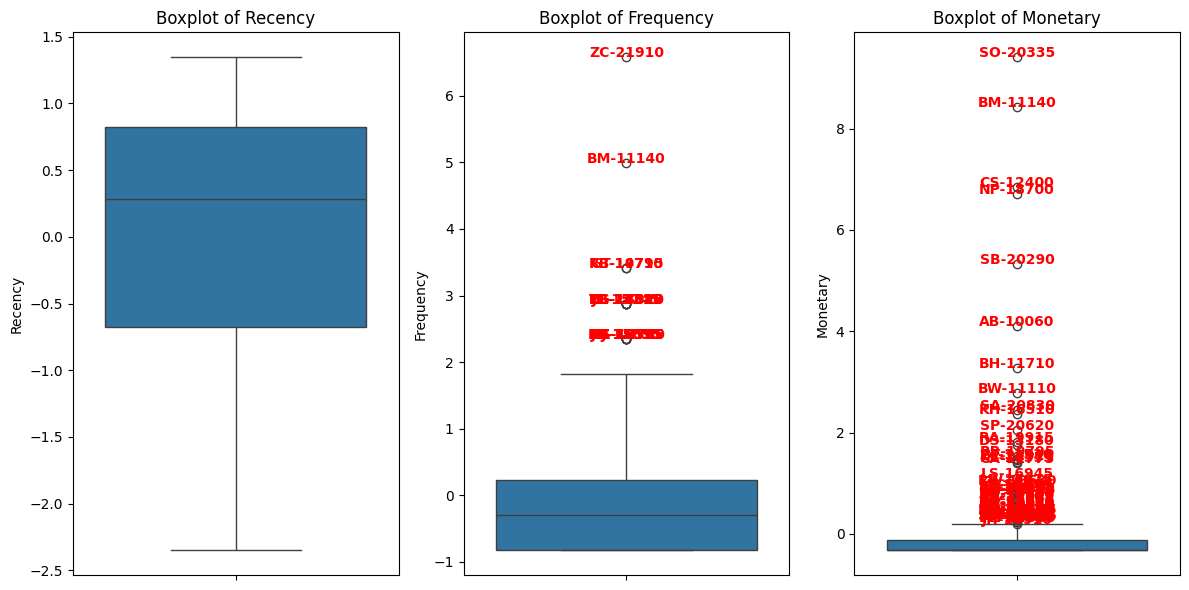

In [3]:
#3.Code vẽ boxplot cho từng chỉ số RFM
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu từ file
file_path = r"D:\KỲ 2 2024-2025\PYTHON\rfm_analysis_zscore.xlsx"
df = pd.read_excel(file_path)

# Xác định các cột RFM
rfm_columns = ['Recency', 'Frequency', 'Monetary']

# Vẽ boxplot cho từng chỉ số RFM
plt.figure(figsize=(12, 6))
for i, col in enumerate(rfm_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    
    # Tìm ngoại lệ theo IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    
    # Nếu là cột Frequency, chỉ lấy ngoại lệ tối đa là 15
    if col == 'Frequency':
        outliers = df[(df[col] > upper_bound) & (df[col] <= 15)]
    else:
        outliers = df[df[col] > upper_bound]
    
    # Hiển thị Customer_ID trên từng điểm ngoại lệ
    for idx, row in outliers.iterrows():
        plt.text(0, row[col], f'{row["Customer_ID"]}', ha='center', color='red', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

Kích thước dữ liệu sau khi lọc ngoại lệ:
Số dòng: 320
Số cột: 4


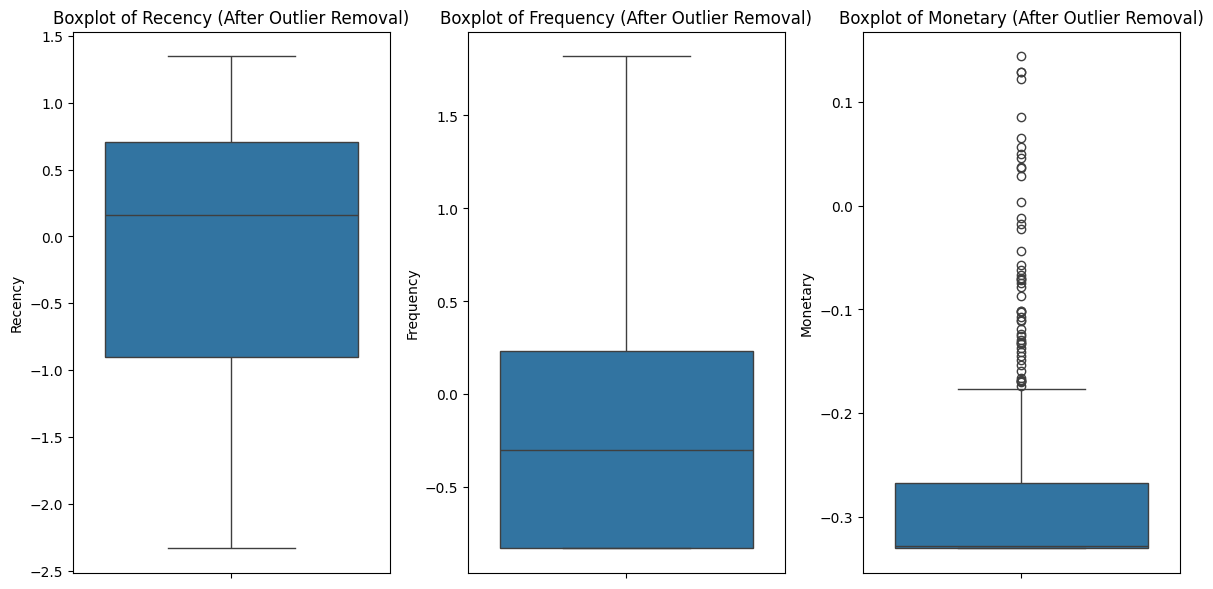

Dữ liệu đã được làm sạch và lưu vào: D:\KỲ 2 2024-2025\PYTHON\rfm_analysis_cleaned.xlsx


In [ ]:
#4. Loại bỏ ngoại lệ theo IQR
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu từ file
file_path = r"D:\KỲ 2 2024-2025\PYTHON\rfm_analysis_zscore.xlsx"
df = pd.read_excel(file_path)

# Xác định các cột RFM
rfm_columns = ['Recency', 'Frequency', 'Monetary']

# Loại bỏ ngoại lệ theo IQR
for col in rfm_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Giữ lại các giá trị trong khoảng hợp lệ
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# In ra số dòng và số cột sau khi lọc
print("Kích thước dữ liệu sau khi lọc ngoại lệ:")
print(f"Số dòng: {df.shape[0]}")
print(f"Số cột: {df.shape[1]}")

# Lưu dữ liệu đã xử lý vào file Excel mới
output_file_path = r"D:\KỲ 2 2024-2025\PYTHON\rfm_analysis_cleaned.xlsx"
df.to_excel(output_file_path, index=False)

# Vẽ boxplot sau khi loại bỏ ngoại lệ
plt.figure(figsize=(12, 6))
for i, col in enumerate(rfm_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col} (After Outlier Removal)')

plt.tight_layout()
plt.show()

print(f"Dữ liệu đã được làm sạch và lưu vào: {output_file_path}")


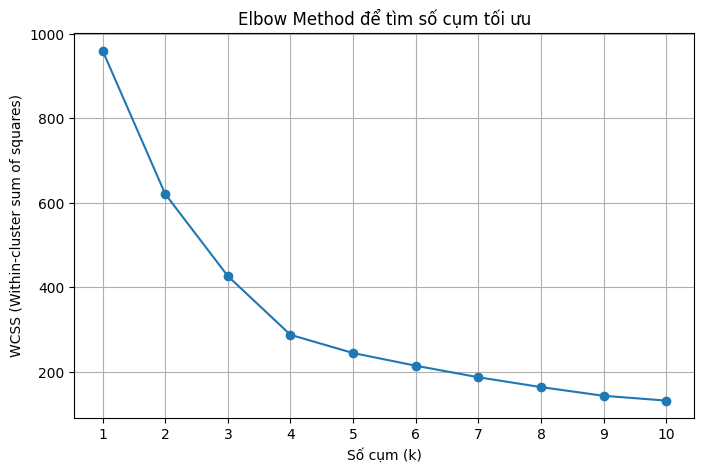

In [5]:
#5.Code tìm số cụm tối ưu bằng phương pháp Elbow
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Đọc dữ liệu từ file
file_path = r"D:\KỲ 2 2024-2025\PYTHON\rfm_analysis_cleaned.xlsx"
df = pd.read_excel(file_path)

# Xác định các cột RFM
rfm_columns = ['Recency', 'Frequency', 'Monetary']
df_rfm = df[rfm_columns]

# Chuẩn hóa dữ liệu (để tránh ảnh hưởng của đơn vị đo)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_rfm)

# Tìm số cụm tối ưu bằng phương pháp Elbow
wcss = []  # Within-cluster sum of squares (tổng bình phương khoảng cách trong cụm)
K_range = range(1, 11)  # Thử từ 1 đến 10 cụm

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ là WCSS

# Vẽ biểu đồ Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='-')
plt.xlabel('Số cụm (k)')
plt.ylabel('WCSS (Within-cluster sum of squares)')
plt.title('Elbow Method để tìm số cụm tối ưu')
plt.xticks(K_range)
plt.grid()
plt.show()


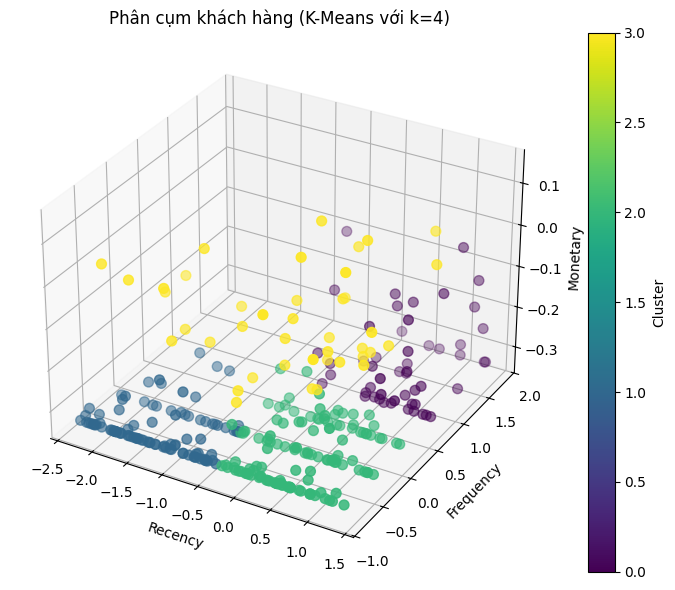

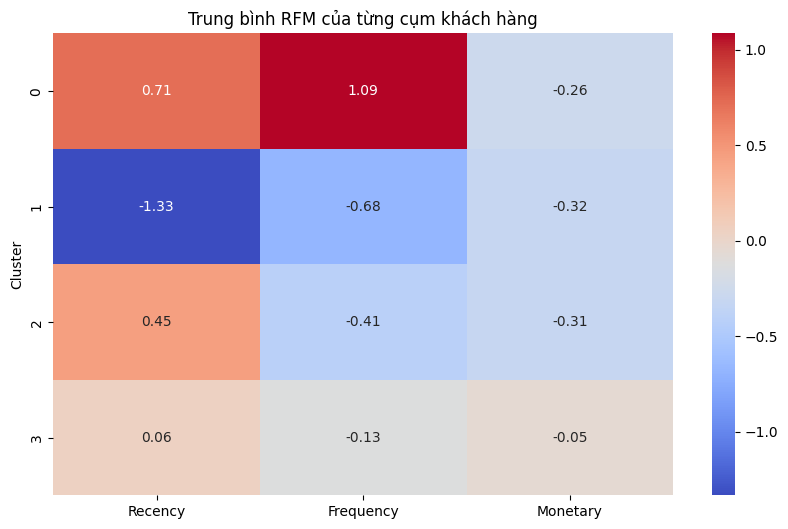

In [ ]:
#6.Code phân cụm khách hàng bằng K-Means
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Đọc dữ liệu từ file
file_path = r"D:\KỲ 2 2024-2025\PYTHON\rfm_analysis_cleaned.xlsx"
df = pd.read_excel(file_path)

# Xác định các cột RFM
rfm_columns = ['Recency', 'Frequency', 'Monetary']
df_rfm = df[rfm_columns]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_rfm)

# Áp dụng K-Means với k = 4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)

#  Biểu đồ phân tán 3D để quan sát các cụm
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['Recency'], df['Frequency'], df['Monetary'], c=df['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('Phân cụm khách hàng (K-Means với k=4)')
plt.colorbar(scatter, label="Cluster")
plt.show()

# Biểu đồ Heatmap để so sánh giá trị trung bình của từng cụm
df_grouped = df.groupby('Cluster')[rfm_columns].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(df_grouped, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Trung bình RFM của từng cụm khách hàng')
plt.show()

In [7]:
#7.Code lọc ra khách hàng thuộc cụm 0
# Lọc ra khách hàng thuộc cụm 0

cluster_0 = df[df['Cluster'] == 0]

# Hiển thị 5 dòng đầu tiê
print(cluster_0.head())

# Xuất ra file Excel nếu cần

cluster_0.to_excel(r"D:\KỲ 2 2024-2025\PYTHON\cluster_0.xlsx", index=False)
print("Đã lưu cụm 0 vào file cluster_0.xlsx")


   Customer_ID   Recency  Frequency  Monetary  Cluster
1     AA-10375  1.066968   0.760067 -0.312789        0
3     AB-10165 -0.076449   0.760067 -0.300907        0
18    AP-10915  0.608080   1.289400 -0.304268        0
20    AR-10510  0.506669   0.760067 -0.249085        0
32    BD-11605  1.264721   0.760067 -0.329536        0
Đã lưu cụm 0 vào file cluster_0.xlsx


In [8]:
#8.Code lọc ra khách hàng thuộc cụm 1
# Lọc ra khách hàng thuộc cụm 1
cluster_1 = df[df['Cluster'] == 1]

# Hiển thị 5 dòng đầu tiên
print(cluster_1.head())

# Xuất ra file Excel nếu cần
cluster_1.to_excel(r"D:\KỲ 2 2024-2025\PYTHON\cluster_1.xlsx", index=False)
print("Đã lưu cụm 1 vào file cluster_1.xlsx")


   Customer_ID   Recency  Frequency  Monetary  Cluster
2     AA-10480 -1.645795  -0.827931 -0.314222        1
5     AG-10270 -1.820731  -0.827931 -0.329958        1
7     AG-10495 -1.625513  -0.298598 -0.269353        1
14    AJ-10945 -0.461813  -0.827931 -0.310257        1
23    AS-10225 -1.143807  -0.827931 -0.329987        1
Đã lưu cụm 1 vào file cluster_1.xlsx


In [9]:
#9.Code lọc ra khách hàng thuộc cụm 2
# Lọc ra khách hàng thuộc cụm 2
cluster_2 = df[df['Cluster'] == 2]

# Hiển thị 5 dòng đầu tiên
print(cluster_2.head())

# Xuất ra file Excel nếu cần
cluster_2.to_excel(r"D:\KỲ 2 2024-2025\PYTHON\cluster_2.xlsx", index=False)
print("Đã lưu cụm 2 vào file cluster_2.xlsx")

   Customer_ID   Recency  Frequency  Monetary  Cluster
0     AA-10315  0.760198  -0.827931 -0.330003        2
4     AF-10885  1.252045  -0.298598 -0.329637        2
6     AG-10390  0.504133   0.230735 -0.296756        2
11    AH-10210  1.148098  -0.827931 -0.329933        2
12    AJ-10780  0.912316  -0.298598 -0.329959        2
Đã lưu cụm 2 vào file cluster_2.xlsx


In [10]:
#10.Code lọc ra khách hàng thuộc cụm 3
# Lọc ra khách hàng thuộc cụm 3
cluster_3 = df[df['Cluster'] == 3]

# Hiển thị 5 dòng đầu tiên
print(cluster_3.head())

# Xuất ra file Excel nếu cần
cluster_3.to_excel(r"D:\KỲ 2 2024-2025\PYTHON\cluster_3.xlsx", index=False)
print("Đã lưu cụm 3 vào file cluster_3.xlsx")

   Customer_ID   Recency  Frequency  Monetary  Cluster
8     AG-10525  0.118769  -0.298598 -0.133077        3
9     AG-10675  1.112604   0.230735 -0.101865        3
10    AH-10195  0.699351  -0.298598 -0.071048        3
13    AJ-10795  0.869216   0.230735 -0.129934        3
21    AR-10825  0.488922   0.230735 -0.022622        3
Đã lưu cụm 3 vào file cluster_3.xlsx


In [11]:
#11.Code kiểm định ANOVA cho từng chỉ số RFM
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Đọc dữ liệu từ các file Excel
files = [f"D:/KỲ 2 2024-2025/PYTHON/cluster_{i}.xlsx" for i in range(4)]
clusters = []

for i, file in enumerate(files):
    df = pd.read_excel(file)
    df['Cluster'] = i  # Gán nhãn cụm
    clusters.append(df)

# Gộp dữ liệu từ 4 cụm vào một DataFrame chung
df_combined = pd.concat(clusters, ignore_index=True)

# Xác định các cột RFM
rfm_columns = ['Recency', 'Frequency', 'Monetary']

# Kiểm định ANOVA cho từng chỉ số RFM
for col in rfm_columns:
    model = ols(f'{col} ~ C(Cluster)', data=df_combined).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\nKết quả kiểm định ANOVA cho {col}:")
    print(anova_table)


Kết quả kiểm định ANOVA cho Recency:
                sum_sq     df           F        PR(>F)
C(Cluster)  223.583203    3.0  231.027845  2.523114e-79
Residual    101.939072  316.0         NaN           NaN

Kết quả kiểm định ANOVA cho Frequency:
                sum_sq     df           F        PR(>F)
C(Cluster)  114.042896    3.0  229.835623  4.418104e-79
Residual     52.265694  316.0         NaN           NaN

Kết quả kiểm định ANOVA cho Monetary:
              sum_sq     df           F        PR(>F)
C(Cluster)  2.455436    3.0  282.449459  4.496858e-89
Residual    0.915701  316.0         NaN           NaN


In [12]:
#12.Code kiểm định Tukey HSD cho từng chỉ số RFM
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Đọc dữ liệu từ các file Excel
files = [f"D:/KỲ 2 2024-2025/PYTHON/cluster_{i}.xlsx" for i in range(4)]
clusters = []

for i, file in enumerate(files):
    df = pd.read_excel(file)
    df['Cluster'] = i  # Gán nhãn cụm
    clusters.append(df)

# Gộp dữ liệu từ 4 cụm vào một DataFrame chung
df_combined = pd.concat(clusters, ignore_index=True)

# Xác định các cột RFM
rfm_columns = ['Recency', 'Frequency', 'Monetary']

# Kiểm định Tukey HSD cho từng chỉ số RFM
for col in rfm_columns:
    print(f"\nTukey HSD - {col}:")
    tukey = pairwise_tukeyhsd(df_combined[col], df_combined['Cluster'])
    print(tukey)


Tukey HSD - Recency:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -2.0456    0.0 -2.2973 -1.7939   True
     0      2  -0.2608 0.0281 -0.5017 -0.0198   True
     0      3  -0.6585    0.0 -0.9649 -0.3522   True
     1      2   1.7849    0.0  1.5883  1.9814   True
     1      3   1.3871    0.0  1.1142  1.6599   True
     2      3  -0.3978 0.0007 -0.6608 -0.1348   True
----------------------------------------------------

Tukey HSD - Frequency:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -1.7625    0.0 -1.9427 -1.5823   True
     0      2  -1.4952    0.0 -1.6677 -1.3227   True
     0      3  -1.2166    0.0  -1.436 -0.9972   True
     1      2   0.2673    0.0  0.1266  0.4081   True
     1      3   0.5459    0.0  0.3506  0.7413   True


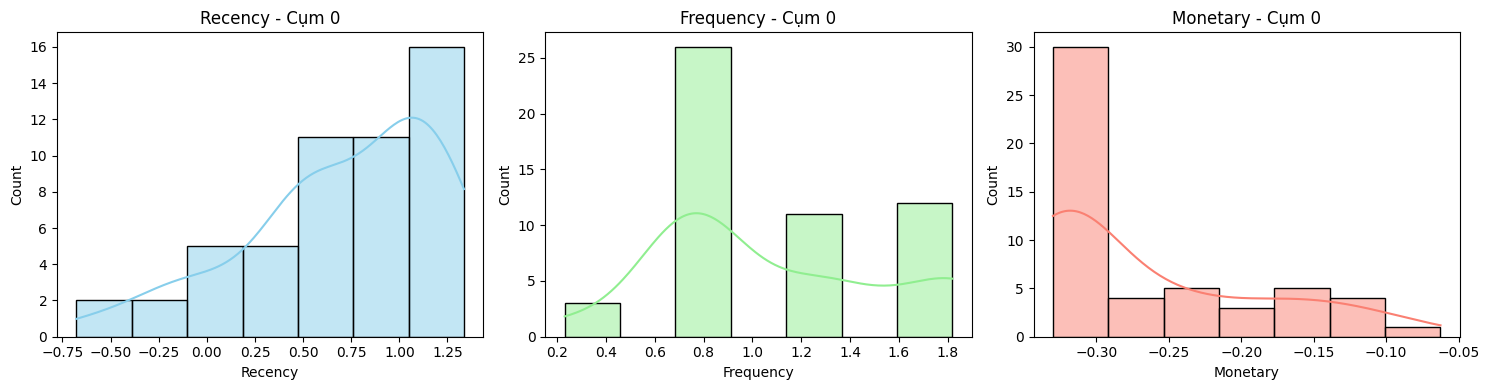

In [ ]:
#13. Code vẽ biểu đồ phân phối cho từng chỉ số RFM của cụm 0
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

file_path_0 = r"D:\KỲ 2 2024-2025\PYTHON\cluster_0.xlsx"
data_0 = pd.read_excel(file_path_0)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.histplot(data_0['Recency'], kde=True, color='skyblue')
plt.title('Recency - Cụm 0')

plt.subplot(1, 3, 2)
sns.histplot(data_0['Frequency'], kde=True, color='lightgreen')
plt.title('Frequency - Cụm 0')

plt.subplot(1, 3, 3)
sns.histplot(data_0['Monetary'], kde=True, color='salmon')
plt.title('Monetary - Cụm 0')

plt.tight_layout()
plt.show()


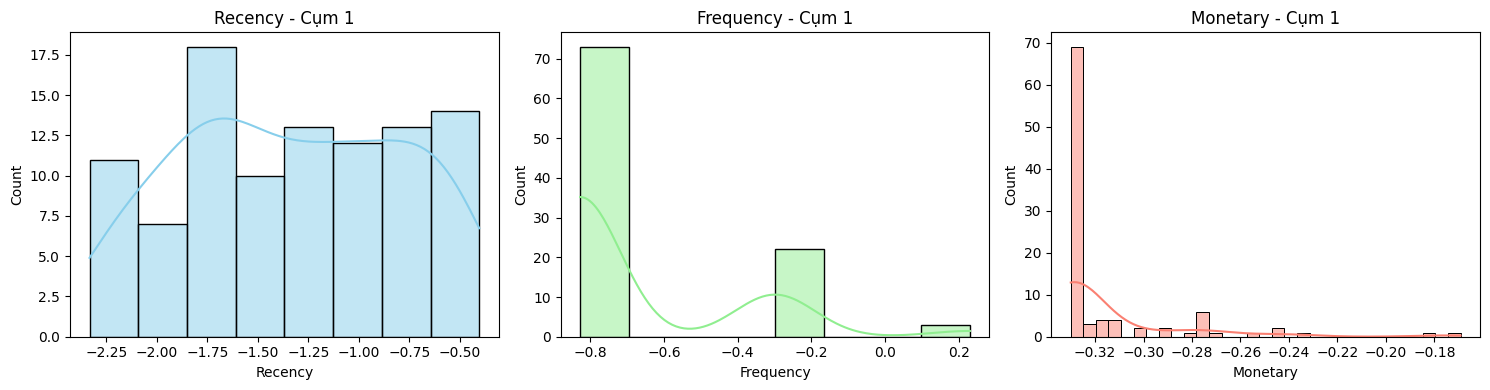

In [ ]:
#14. Code vẽ biểu đồ phân phối cho từng chỉ số RFM của cụm 1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

file_path_1 = r"D:\KỲ 2 2024-2025\PYTHON\cluster_1.xlsx"
data_1 = pd.read_excel(file_path_1)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.histplot(data_1['Recency'], kde=True, color='skyblue')
plt.title('Recency - Cụm 1')

plt.subplot(1, 3, 2)
sns.histplot(data_1['Frequency'], kde=True, color='lightgreen')
plt.title('Frequency - Cụm 1')

plt.subplot(1, 3, 3)
sns.histplot(data_1['Monetary'], kde=True, color='salmon')
plt.title('Monetary - Cụm 1')

plt.tight_layout()
plt.show()


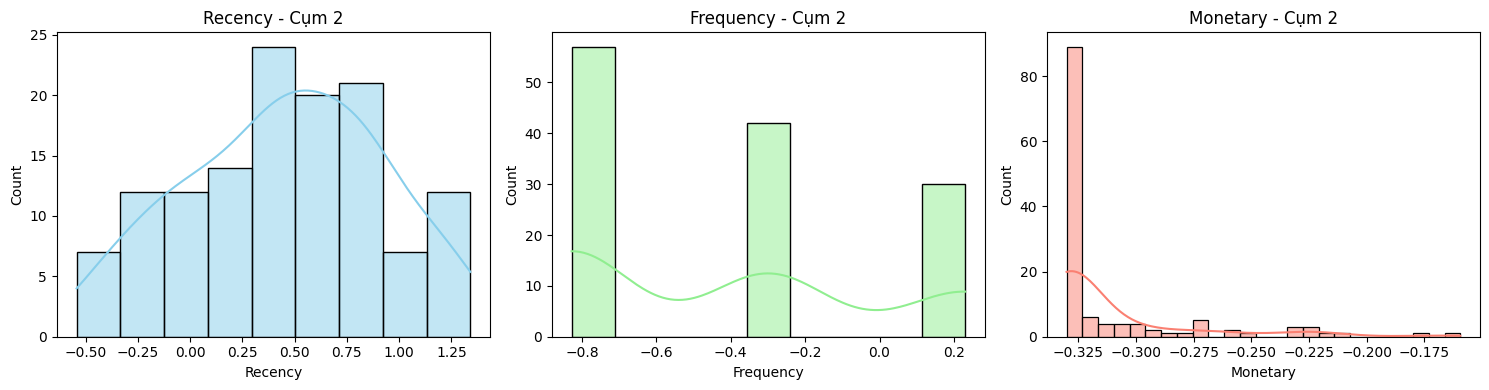

In [ ]:
#15. Code vẽ biểu đồ phân phối cho từng chỉ số RFM của cụm 2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

file_path_2 = r"D:\KỲ 2 2024-2025\PYTHON\cluster_2.xlsx"
data_2 = pd.read_excel(file_path_2)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.histplot(data_2['Recency'], kde=True, color='skyblue')
plt.title('Recency - Cụm 2')

plt.subplot(1, 3, 2)
sns.histplot(data_2['Frequency'], kde=True, color='lightgreen')
plt.title('Frequency - Cụm 2')

plt.subplot(1, 3, 3)
sns.histplot(data_2['Monetary'], kde=True, color='salmon')
plt.title('Monetary - Cụm 2')

plt.tight_layout()
plt.show()


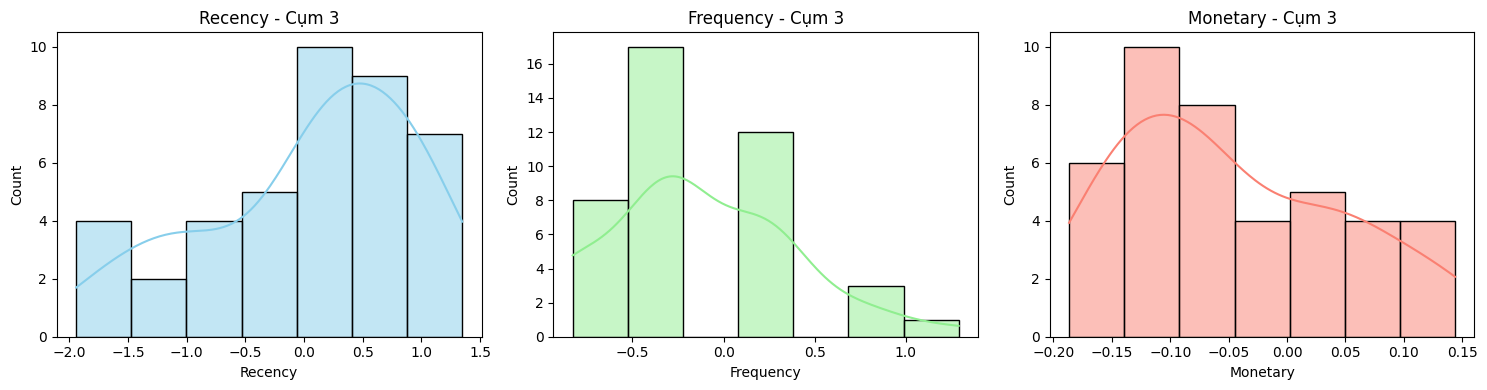

In [ ]:
#16. Code vẽ biểu đồ phân phối cho từng chỉ số RFM của cụm 3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

file_path_3 = r"D:\KỲ 2 2024-2025\PYTHON\cluster_3.xlsx"
data_3 = pd.read_excel(file_path_3)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.histplot(data_3['Recency'], kde=True, color='skyblue')
plt.title('Recency - Cụm 3')

plt.subplot(1, 3, 2)
sns.histplot(data_3['Frequency'], kde=True, color='lightgreen')
plt.title('Frequency - Cụm 3')

plt.subplot(1, 3, 3)
sns.histplot(data_3['Monetary'], kde=True, color='salmon')
plt.title('Monetary - Cụm 3')

plt.tight_layout()
plt.show()
